In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import scipy, scipy.linalg, scipy.sparse, scipy.sparse.linalg, scipy.fftpack
plt.rcParams['figure.figsize'] = 10, 6
%matplotlib notebook

# Exercise 1.2 Stopping light

## Useful functions

### Generate the initial wave packet

In [16]:
x_0 = -10.
k_0 = 5.
a = 1

In [17]:
#Exact solution
def exact_wavepacket(x, t=0, a=a, k=k_0, x_0=x_0):
    return (
        (np.pi * a**2 / 2)**(-1. / 4) *
        np.sqrt(a**2 / (a**2 + 2j * t)) *
        np.exp(1j*(k_0*x - k_0**2 * t / 2)) *
        np.exp(-(x - x_0 - k_0 * t)**2 / (a**2 + 2j * t))
    )

### (Discretized) Hamiltonian for given potential:

In [18]:
def hamiltonian(V, xs, dx):
    diag = V(xs) + 1. / dx**2
    offdiag = -0.5 / dx**2 * np.ones(x_steps)
    return scipy.sparse.dia_matrix(
        ([diag, offdiag, offdiag], [0, -1, 1]), 
        shape=(len(xs), len(xs))
    )

### Create animations 

In [49]:
def display_evo(wave_step, xs, dx, ts, dt, V=None):
    fig, ax1 = plt.subplots()
    if V:
        ax2 = ax1.twinx()
        ax2.set_aspect('equal')
        ax2.plot(xs, V(xs), '--', color='gray')
        for tl in ax2.get_yticklabels():
            tl.set_color('gray')
    
    line_real, = ax1.plot([], [], 'r-', label="Re \Psi")
    line_imag, = ax1.plot([], [], 'g-', label="Im \Psi")
    line_abs_sqr, = ax1.plot([], [], 'b-', lw=2, label="|\Psi|^2")
    
    ax1.set_xlim(min(xs), max(xs))
    ax1.set_ylim(-1, 1)
    ax1.set_xlabel("x")
    ax1.axvline(0, ls="--", color="gray")
    ax1.legend()
    
    def update(t):
        psi = wave_step(dt, t)
        line_real.set_data(xs, psi.real)
        line_imag.set_data(xs, psi.imag)
        line_abs_sqr.set_data(xs, np.abs(psi)**2)
        return [line_real, line_imag, line_abs_sqr]
    
    anim=FuncAnimation(fig, update, ts, blit=True,interval=1000*dt)
    plt.show()
    return anim

## Free propagation

### Discretization parameters:

In [32]:
x_min = -50
x_max = 50
x_steps = 5000
xs, dx = np.linspace(x_min, x_max, x_steps, retstep=True)

t_min = 0
t_max = 15
t_steps = 400 
ts, dt = np.linspace(t_min, t_max, t_steps, retstep=True)

In [33]:
V_free = np.vectorize(lambda x: 0)
H_free = hamiltonian(V_free, xs=xs, dx=dx)

### Exact Solution:

<IPython.core.display.Javascript object>


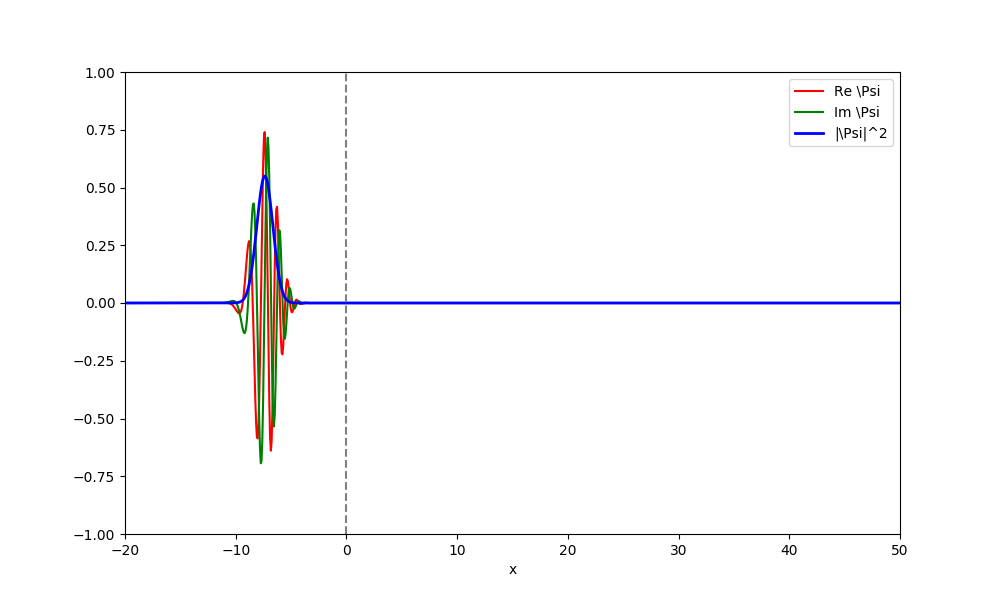

In [50]:
display_evo( lambda dt, t: exact_wavepacket(xs, t), xs=xs, dx=dx, ts=ts, dt=dt)

It is apparent from the analytical solution that the time-evolved wavepacket is again a wavepacket:
More precisely, the probability amplitude follows a Gaussian distribution with center $x_0 + k_0 t$ and spread $\sqrt{(a/2)^2 + (t/a)^2}$.
The probability current is given by $\mathrm{Im} \Psi^* \nabla \Psi$. It can be interpreted as $v(x) |\Psi(x)|^2$, with $v(x)$ the "local velocity". Hence, its integral gives the average velocity, which for our wave packet is equal to $k_0$. The local kinetic energy can also be readily computed. Here is a snapshot:

<IPython.core.display.Javascript object>


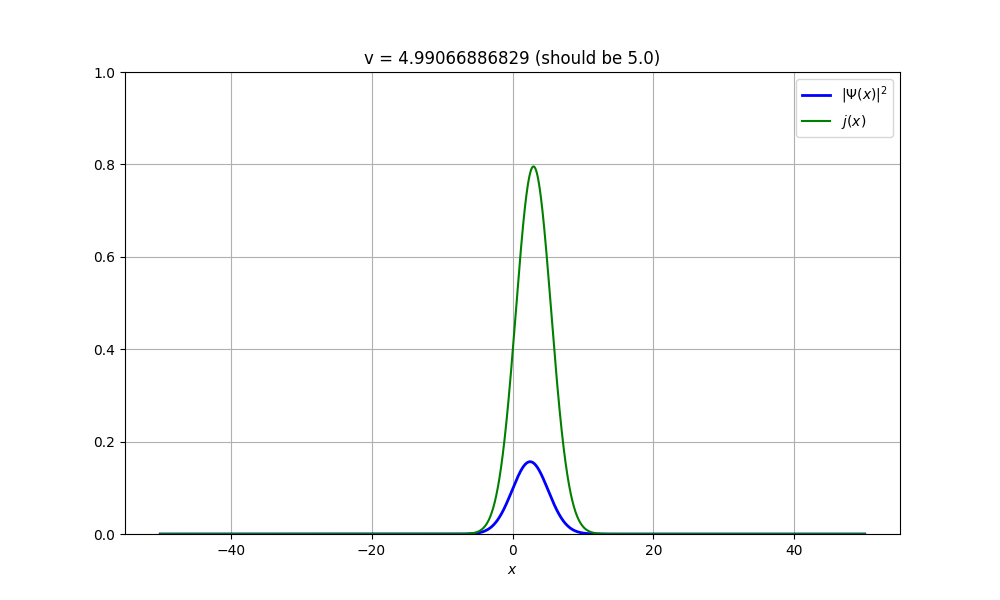

In [35]:
def prob_current(psi, dx):
    psi_mean = (psi[1:] + psi[:-1]) / 2. 
    psi_prime = np.diff(psi).conj() / dx
    return -(psi_mean * psi_prime).imag

def velocity(psi, dx):
    return sum(prob_current(psi, dx) * dx)

t = 2.5
xs_mid = (xs[1:]+xs[:-1])/2

f=plt.figure()
plt.ylim(bottom=0)
plt.plot(xs, np.abs(exact_wavepacket(xs, t))**2, color="blue", lw=2, label="$|\Psi(x)|^2$")
plt.plot(xs_mid, prob_current(exact_wavepacket(xs, t), dx), color="green", label="$j(x)$")
plt.xlabel('$x$')
plt.grid()
plt.title('v = {} (should be {})'.format(velocity(exact_wavepacket(xs, t), dx), k_0))
plt.legend()

### Spectral time evolution:

In [36]:
class SpectralEvolution:
    def __init__(self, H, initial_psi):
        self.H = H.todense()
        self.energies, self.eigenstates = scipy.linalg.eigh(self.H)
        self.initial_psi = np.dot(self.eigenstates.T.conj(), initial_psi)   # to get a unit vector, we should multiply by sqrt(dx)    
    
    def __call__(self, dt, t):
        psi = np.exp(-1j * self.energies * t) * self.initial_psi
        return np.dot(self.eigenstates, psi)

In [37]:
result=SpectralEvolution(H_free, exact_wavepacket(xs))

<IPython.core.display.Javascript object>


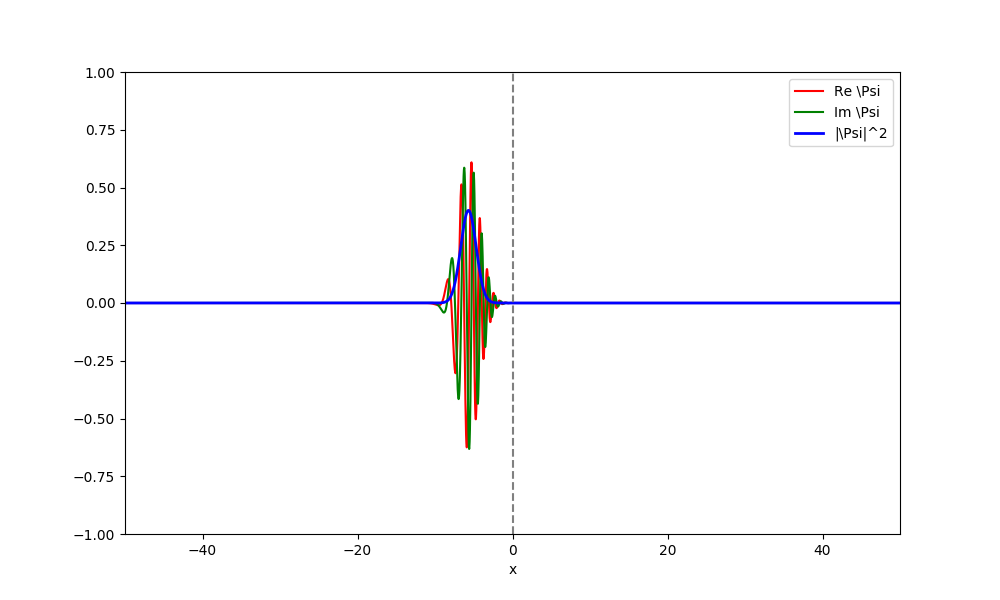

In [38]:
display_evo(result, xs=xs, dx=dx, ts=ts, dt=dt)

### Forward Euler scheme:

In [39]:
import functools

class EulerEvolution:
    def __init__(self, H, initial_psi):
        self.H = H # np.array(H.todense())
        self.current_psi = initial_psi.reshape(-1, 1)
   
    def _operator(self, dt):
        return scipy.sparse.identity(x_steps) - 1j * dt * self.H

    def __call__(self, dt, t):
        A = self._operator(dt)
        psi = A.dot(self.current_psi)
        self.current_psi = psi / np.linalg.norm(psi) * np.linalg.norm(self.current_psi)
        return self.current_psi

<IPython.core.display.Javascript object>


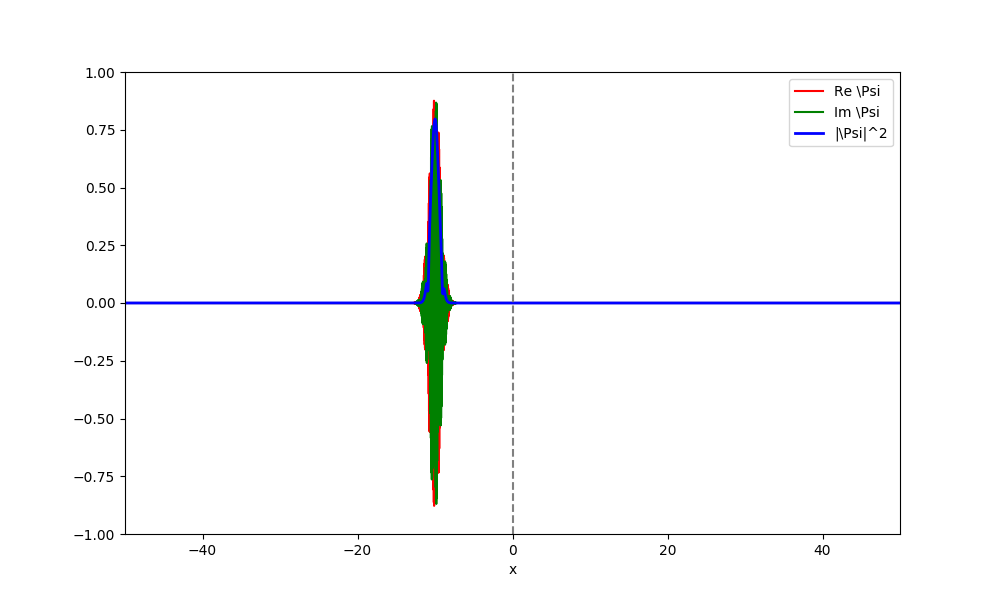

In [40]:
display_evo( EulerEvolution(H_free, exact_wavepacket(xs)), xs=xs, dx=dx, ts=ts, dt=dt)

### Forward/Backward stable, unitary scheme:

In [41]:
class StableEvolution:
    def __init__(self, H, initial_psi):
        self.H = H
        self.current_psi = initial_psi
    
    #@functools.lru_cache(maxsize=1)
    def _operator(self, dt):
        return scipy.sparse.identity(len(self.current_psi)) - 0.5j * dt * self.H
    
    #@functools.lru_cache(maxsize=1)
    def _operator_conj(self, dt):
        return self._operator(dt).conj()
        
    def __call__(self, dt, t):
        tmp = self._operator(dt).dot(self.current_psi)
        self.current_psi = scipy.sparse.linalg.spsolve(self._operator_conj(dt), tmp)
        return self.current_psi

<IPython.core.display.Javascript object>


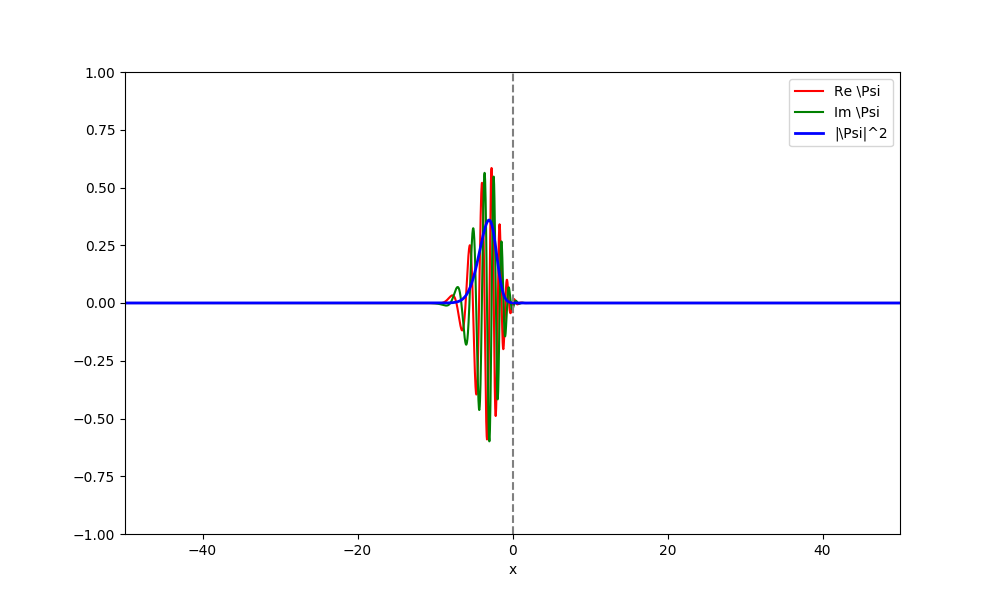

In [42]:
display_evo( StableEvolution(H_free, exact_wavepacket(xs)), xs=xs, dx=dx, ts=ts, dt=dt)

### Split operator method (assumes periodic b.c., hence only valid as long as the wave function does not exceed x_min or x_max):

In [43]:
class SplitOperatorMethod:
    def __init__(self, V, initial_psi, xs):
        self.V = V(xs)
        self.current_psi = initial_psi
        freqs = scipy.fftpack.fftfreq(len(xs))
        self.neg_laplace = (2 * np.pi * (len(xs) - 1) / (max(xs) - min(xs)) * freqs)**2

    #@functools.lru_cache(maxsize=1)
    def _exp_V(self, dt):
        return np.exp(-0.5j * dt * self.V)
    
    #@functools.lru_cache(maxsize=1)
    def _exp_neg_laplace(self, dt):
        return np.exp(-1j * dt * self.neg_laplace / 2)
        
    def __call__(self, dt, t):
        exp_V = self._exp_V(dt)
        psi = exp_V * self.current_psi
        psi = scipy.fftpack.fft(psi)
        psi = self._exp_neg_laplace(dt) * psi
        psi = scipy.fftpack.ifft(psi)
        self.current_psi = exp_V * psi
        return self.current_psi



<IPython.core.display.Javascript object>


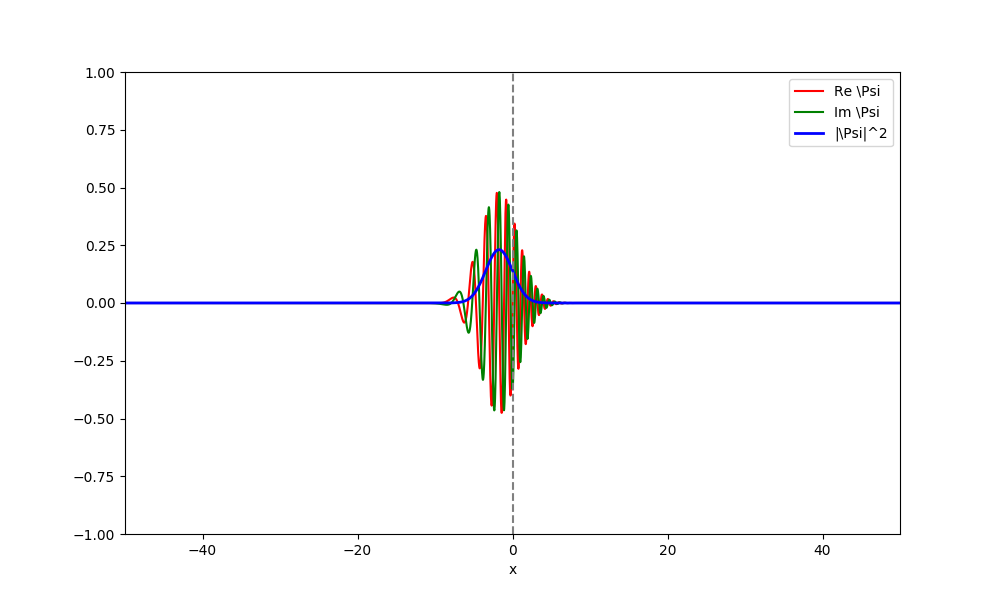

In [44]:
display_evo( SplitOperatorMethod(V_free, exact_wavepacket(xs), xs), xs=xs, dx=dx, ts=ts, dt=dt)

## Tilted Wall

### Re-set simulation range:

In [45]:
x_min = -20
x_max = 50
x_steps = 1000
xs, dx = np.linspace(x_min, x_max, x_steps, retstep=True)

### Potential:

In [46]:
def V_wall(theta_deg):
    m = np.tan(theta_deg*2*np.pi/360)
    return np.vectorize(lambda x: max(.0, m*x))

def H_wall(theta_deg, xs, dx):
    return hamiltonian(V_wall(theta_deg), xs=xs, dx=dx)

### Time evolution of the wave function and of the average velocity:

<IPython.core.display.Javascript object>


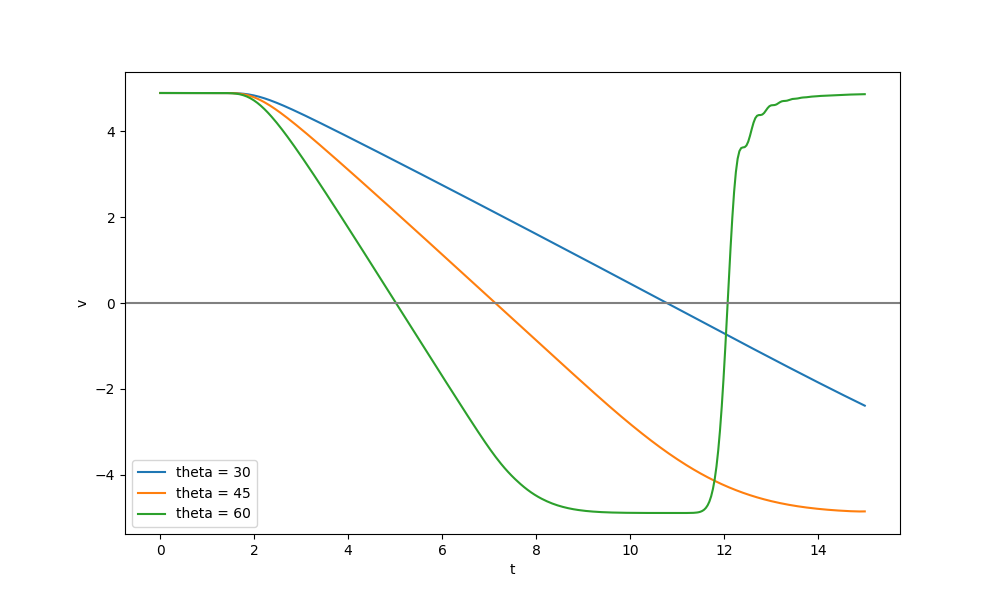

In [47]:
def velocities(theta_deg):
    evol = SpectralEvolution(H_wall(theta_deg, xs=xs, dx=dx), exact_wavepacket(xs))
    vs = [velocity(exact_wavepacket(xs, 0), dx=dx)]
    for t in ts[1:]:
        psi = evol(dt, t)
        vs.append(velocity(psi, dx=dx))
    return vs
f=plt.figure()
plt.xlabel("t")
plt.ylabel("v")
for theta_deg in [30, 45, 60]:
    vs = velocities(theta_deg)
    plt.plot(ts, vs, label="theta = %d" % theta_deg)
plt.legend()
plt.axhline(0, color="gray")

<IPython.core.display.Javascript object>


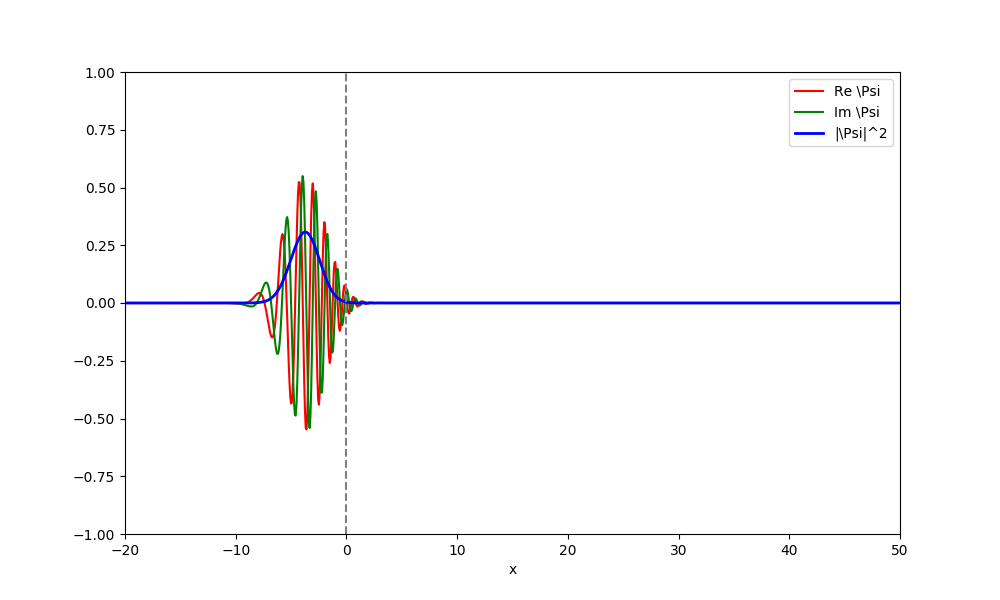

In [48]:
display_evo( 
    SpectralEvolution(H_wall(45, xs=xs, dx=dx), exact_wavepacket(xs)), 
    xs=xs, dx=dx, ts=ts, dt=dt,
    #V=V_wall(45),
    )